In [5]:
# Overall tools
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import sys
import os
from pathlib import Path
from pprint import pprint

# Progress bar for the loops
import time
import sys
import tqdm

# Text tools
import re, nltk, spacy, gensim
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('wordnet')

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

#plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup
from bokeh.models import TextInput
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.models import Paragraph
from bokeh.layouts import column, widgetbox


# Importing libraries







[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Beatriz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Beatriz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Beatriz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
p_df = pd.read_csv('Papers.csv')

In [7]:
p_df.head()

,Id,Title,EventType,PdfName,Abstract,PaperText
0,5677,Double or Nothing: Multiplicative Incentive Me...,Poster,5677-double-or-nothing-multiplicative-incentiv...,Crowdsourcing has gained immense popularity in...,Double or Nothing: Multiplicative\nIncentive M...
1,5941,Learning with Symmetric Label Noise: The Impor...,Spotlight,5941-learning-with-symmetric-label-noise-the-i...,Convex potential minimisation is the de facto ...,Learning with Symmetric Label Noise: The\nImpo...
2,6019,Algorithmic Stability and Uniform Generalization,Poster,6019-algorithmic-stability-and-uniform-general...,One of the central questions in statistical le...,Algorithmic Stability and Uniform Generalizati...
3,6035,Adaptive Low-Complexity Sequential Inference f...,Poster,6035-adaptive-low-complexity-sequential-infere...,We develop a sequential low-complexity inferen...,Adaptive Low-Complexity Sequential Inference f...
4,5978,Covariance-Controlled Adaptive Langevin Thermo...,Poster,5978-covariance-controlled-adaptive-langevin-t...,Monte Carlo sampling for Bayesian posterior in...,Covariance-Controlled Adaptive Langevin\nTherm...


In [8]:
len(p_df)

403

In [9]:
# Creating a list of stopwords in english

english_stopwords = list(set(stopwords.words('english')))

In [10]:
# Creating a lemmatizing function

lmtzr = WordNetLemmatizer()

In [11]:
# Creating a stem function

porter = PorterStemmer()

In [12]:
# Creating a function that cleans text of special characters

def strip_characters(text):
    t = re.sub('\(|\)|:|,|;|\.|’|”|“|\?|%|>|<', '', text)
    t = re.sub('/', ' ', t)
    t = t.replace("'",'')
    return t

<>:4: DeprecationWarning: invalid escape sequence \(
<>:4: DeprecationWarning: invalid escape sequence \(
<>:4: DeprecationWarning: invalid escape sequence \(
<ipython-input-12-b498eeac4b3b>:4: DeprecationWarning: invalid escape sequence \(
  t = re.sub('\(|\)|:|,|;|\.|’|”|“|\?|%|>|<', '', text)


In [13]:
# Creating a function that makes text lowercase and uses the function created above

def clean(text):
    t = text.lower()
    t = strip_characters(t)
    return t

In [14]:
# Tokenize into individual tokens - words mostly

def tokenize(text):
    words = nltk.word_tokenize(text)
    return list(set([word for word in words 
                     if len(word) > 1
                     and not word in english_stopwords
                     and not (word.isnumeric() and len(word) is not 4)
                     and (not word.isnumeric() or word.isalpha())] )
               )

In [15]:
# Creating a function that cleans, lemmatize and tokenize texts

def preprocess(text):
    t = clean(text)
    tokens = tokenize(t)
    l = [lmtzr.lemmatize(word) for word in tokens]
    return tokens# Creating a function that cleans, lemmatize and tokenize texts

In [16]:
def stemming(text):
    stem_sentence=[]
    for word in text:
        stem_sentence.append(porter.stem(word))
    return "".join(stem_sentence)

In [52]:
# Creating a list of stopwords in english

stop_words = list(set(stopwords.words('english')))
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say',
                   'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather',
                   'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [17]:
# Preprocessing all the strings inside the column abstract. It will make them lowercase, remove special characters, stopwords and tokenize them.
p_df['PaperText_Processed'] = p_df['PaperText'].apply(lambda x: preprocess(x))

In [18]:
abstract = p_df['PaperText_Processed'].tolist()
len(abstract)

403

In [19]:
id2word = corpora.Dictionary(abstract)

In [21]:
corpus = [id2word.doc2bow(text) for text in abstract]

In [22]:
from gensim.models.ldamulticore import LdaMulticore

In [24]:
lda = LdaMulticore(corpus, id2word=id2word, num_topics=3)

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=3)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus, texts=abstract, start=1, limit=10, step=1)

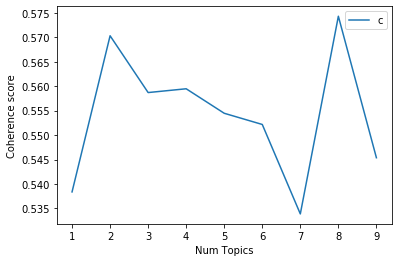

In [31]:
# Show graph
limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.5384
Num Topics = 2  has Coherence Value of 0.5703
Num Topics = 3  has Coherence Value of 0.5587
Num Topics = 4  has Coherence Value of 0.5595
Num Topics = 5  has Coherence Value of 0.5545
Num Topics = 6  has Coherence Value of 0.5522
Num Topics = 7  has Coherence Value of 0.5339
Num Topics = 8  has Coherence Value of 0.5743
Num Topics = 9  has Coherence Value of 0.5454


In [33]:
lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=6, 
                        random_state=42,
                        chunksize=150,
                        passes=30,
                        iterations = 500,
                        per_word_topics=True)

In [34]:
# Compute Perplexity (lower = better)

print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -9.77434058864641


In [37]:
# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=abstract, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6111887267395161


In [38]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.200142  0.008838       1        1  54.661911
5      0.191652  0.004139       2        1  37.819225
2      0.009252 -0.061827       3        1   3.659075
1     -0.086983  0.080871       4        1   1.855438
4     -0.146522 -0.015236       5        1   1.019515
3     -0.167542 -0.016784       6        1   0.984829, topic_info=                  Term        Freq       Total Category  logprob  loglift
1295         empirical  213.000000  213.000000  Default  30.0000  30.0000
1253        definition  207.000000  207.000000  Default  29.0000  29.0000
1096   acknowledgments  162.000000  162.000000  Default  28.0000  28.0000
835           selected  134.000000  134.000000  Default  27.0000  27.0000
1214         computing  250.000000  250.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
31766       inevitably    0.514064    2.854737   Topic6  -9.0507   2.9061
17229        schneider    0.644804    6.852307   Topic6  -8.8241   2.2571
18018         consumed    0.554171    4.063704   Topic6  -8.9756   2.6281
12898        francisco    0.610819    8.534910   Topic6  -8.8783   1.9833
19317        collapses    0.554316    4.644446   Topic6  -8.9753   2.4948

[533 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
53760      6  0.941264            +α
19235      4  0.775931          -140
25667      5  0.937127           -45
6693       1  0.772115  -dimensional
6693       2  0.110302  -dimensional
...      ...       ...           ...
28966      1  0.420812            ∈s
28966      2  0.315609            ∈s
28966      3  0.315609            ∈s
19227      1  0.530068          ﬁrst
19227      4  0.265034          ﬁrst

[994 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 2, 5, 4])

In [39]:
# Select the model and print the topics

optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.001*"given" + 0.001*"also" + 0.001*"used" + 0.001*"however" + '
  '0.001*"model" + 0.001*"abstract" + 0.001*"different" + 0.001*"general" + '
  '0.001*"section" + 0.001*"similar"'),
 (1,
  '0.001*"using" + 0.001*"results" + 0.001*"two" + 0.001*"one" + 0.001*"show" '
  '+ 0.001*"consider" + 0.001*"many" + 0.001*"first" + 0.001*"result" + '
  '0.001*"work"'),
 (2,
  '0.001*"set" + 0.001*"large" + 0.001*"introduction" + 0.001*"learning" + '
  '0.001*"function" + 0.001*"defined" + 0.001*"used" + 0.001*"values" + '
  '0.001*"use" + 0.001*"example"')]


In [40]:
# Find the dominant topic in each sentence

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=abstract):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [42]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=abstract)

In [43]:
# Format

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [44]:
# Show

df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.7460,"set, large, introduction, learning, function, ...","[retrieval, baseline, x1, xg, simulations, des..."
1,1,0.0,0.6118,"given, also, used, however, model, abstract, d...","[predictions, retrieval, artificial, grayed, b..."
2,2,0.0,0.8400,"given, also, used, however, model, abstract, d...","[artificial, next, bounds, three, i=1, experie..."
3,3,2.0,0.6842,"set, large, introduction, learning, function, ...","[artificial, next, posteriors, bounds, capable..."
4,4,2.0,0.4434,"set, large, introduction, learning, function, ...","[auxiliary, article, artificial, ·m∇p, sgld, v..."
5,5,1.0,0.6410,"using, results, two, one, show, consider, many...","[menn, maxdj=1, x1, |vj, od, bounds, next, sim..."
6,6,2.0,0.4946,"set, large, introduction, learning, function, ...","[coding, children, provided, must, schapire, f..."
7,7,0.0,0.5480,"given, also, used, however, model, abstract, d...","[auxiliary, violation, baseline, anytime, θe, ..."
8,8,0.0,0.6425,"given, also, used, however, model, abstract, d...","[retrieval, baseline, named, next, baselines, ..."
9,9,2.0,0.9491,"set, large, introduction, learning, function, ...","[thread, ilp, ordered, treated, pairs, concurr..."


In [45]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9985,"given, also, used, however, model, abstract, d...","[x1, simulations, 21132–40, three, density, i=..."
1,1.0,0.9981,"using, results, two, one, show, consider, many...","[½±²­·¼, ²¬œò, ´ô, ¿´´±©­, îòî, ½±®®, §ô, ·²º,..."
2,2.0,0.9962,"set, large, introduction, learning, function, ...","[artificial, anytime, next, twice, calls, oper..."


In [46]:
# extracting keywords per topic

keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]
keywords.to_csv('keywords.csv')

In [47]:
all_keywords = keywords['Keywords'].values.tolist()
all_keywords = [i.split(',')[1] for i in all_keywords]
all_keywords_unique = keywords['Keywords'].unique().tolist()
count_keywords = len(all_keywords)
count_keywords_svg = keywords['Keywords'].nunique()

In [49]:
all_keywords

[' also', ' results', ' large']

In [50]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,2.0,"set, large, introduction, learning, function, ...",148.0,0.3672
1.0,0.0,"given, also, used, however, model, abstract, d...",107.0,0.2655
2.0,0.0,"given, also, used, however, model, abstract, d...",148.0,0.3672
3.0,2.0,"set, large, introduction, learning, function, ...",NaN,NaN
4.0,2.0,"set, large, introduction, learning, function, ...",NaN,NaN
...,...,...,...,...
398.0,0.0,"given, also, used, however, model, abstract, d...",NaN,NaN
399.0,2.0,"set, large, introduction, learning, function, ...",NaN,NaN
400.0,0.0,"given, also, used, however, model, abstract, d...",NaN,NaN
401.0,1.0,"using, results, two, one, show, consider, many...",NaN,NaN


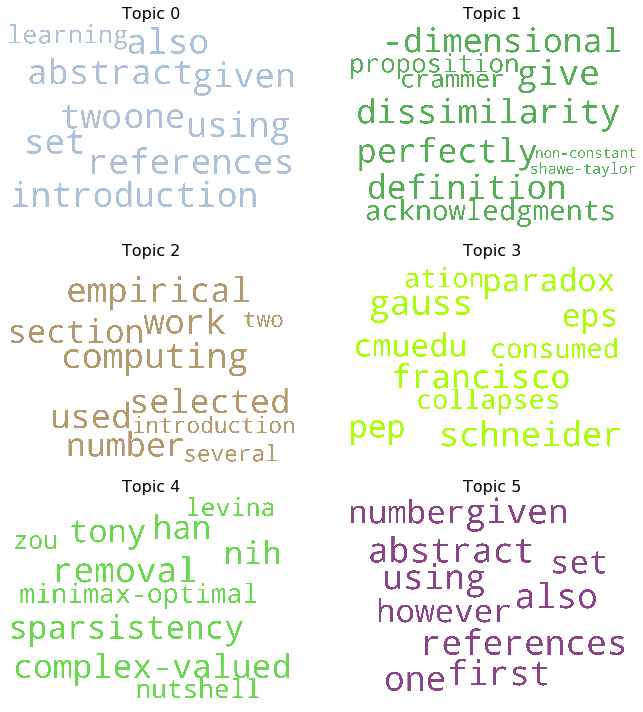

In [54]:
# Creating word clouds for each topic

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [60]:
lda = LdaMulticore(corpus, id2word=id2word, num_topics=5)

In [61]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [62]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus, texts=abstract, start=1, limit=10, step=1)

In [63]:
lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=5, 
                        random_state=42,
                        chunksize=150,
                        passes=30,
                        iterations = 500,
                        per_word_topics=True)

In [64]:
# Compute Perplexity (lower = better)

print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -9.780279823654112


In [65]:
# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=abstract, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5842188002623109


In [66]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.188237 -0.001873       1        1  79.532913
2      0.089593 -0.017461       2        1  12.202712
1      0.003601  0.059180       3        1   4.625233
4     -0.095946 -0.063515       4        1   2.109049
3     -0.185486  0.023669       5        1   1.530099, topic_info=           Term        Freq       Total Category  logprob  loglift
192    consider  329.000000  329.000000  Default  30.0000  30.0000
550         let  312.000000  312.000000  Default  29.0000  29.0000
1029       work  355.000000  355.000000  Default  28.0000  28.0000
1167      bound  237.000000  237.000000  Default  27.0000  27.0000
430     however  360.000000  360.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
12891       eps    0.671485    1.685202   Topic5  -9.2242   3.2597
16012    maxa∈a    0.671458    1.906160   Topic5  -9.2242   3.1364
50527    cmuedu    0.671396    1.686301   Topic5  -9.2243   3.2589
48159       si1    0.671291    2.626504   Topic5  -9.2245   2.8156
41290        pσ    0.670931    1.905927   Topic5  -9.2250   3.1358

[468 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
53760      5  0.841069            +α
25667      4  0.781484           -45
17042      4  0.781463  -divergences
9713       2  0.360689          10th
9713       3  0.721377          10th
...      ...       ...           ...
15894      3  0.215800            ℓ2
71207      5  0.840959            ∇1
32929      4  0.781051            −√
54966      5  0.840629            ∪i
19840      4  0.781493           ⌃⇤k

[924 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 5, 4])